<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Brain-Tumor-Segmentation/blob/main/Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lgg-mri-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F181273%2F407317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T162256Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D70649a582c97d93a21219331f1762708b21b4d8cdbccb04946895d0b324231bd317fe1ab8acc8cd2db8a01010cb80abaa89d9ca1848790c74593f19bc75ee6cf50c50f34fb0d8da86b870bc3ca99f54978828eca7afc61f78a617987574d45156415468b7041c7f8d2cf17b9bbc2d792a1dda172789ca997a427328388bea58c3b911e951fa1f8dd805ba31346543765342c7d599a6f8cb1b528c87a76f0af8b531bafb3d3b7b383ebb18d7c7a3fda9b1fb78aa3b4f3d26d3ec580773c1d0dffbec79c2ef31060ae82594e8ea4b12aba51dc355ae4272c39249fc0865e41cef8e13a6da263309ab03443c79ce697756ea3df4363f5951d50752a23541bef5b7e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 748584920 bytes downloaded
Downloaded and uncompressed: lgg-mri-segmentation
Data source import complete.


In [2]:
import warnings
warnings.filterwarnings(action="ignore")

import os
import cv2
import glob
import numpy as np
import pandas as pd

from tensorflow import keras
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def Load_Data():
    data = {"image":[], "mask":[]}
    img_link = glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif")

    for mask in img_link:
        data["mask"].append(mask)
        data["image"].append(mask.replace("_mask", ""))

    return pd.DataFrame(data)

In [4]:
mri_df = Load_Data()

print(mri_df.shape)

mri_df.head()

(3929, 2)


,image,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


## EDA

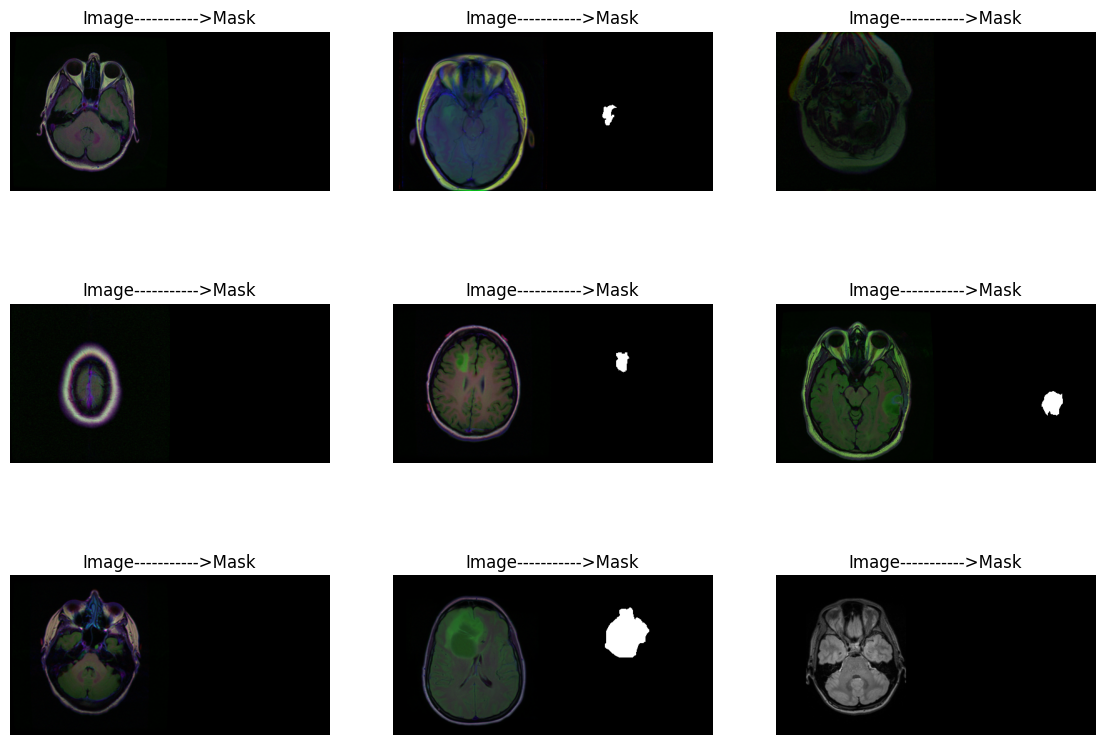

In [5]:
random_sample = np.random.randint(low=0, high=mri_df.shape[0], size=9)

plt.figure(figsize=(14, 10))
for index, i in enumerate(random_sample, start=1):
    plt.subplot(3, 3, index)
    plt.imshow(np.hstack([keras.utils.load_img(mri_df["image"][i]), keras.utils.load_img(mri_df["mask"][i])]))
    plt.title("Image----------->Mask")
    plt.axis("off")

plt.show()

## DATA PREPARATION

In [6]:
train, test = train_test_split(mri_df, train_size=.8, random_state=42)

print(train.shape, test.shape)

(3143, 2) (786, 2)


In [7]:
val = test.sample(n=9)

print(val.shape)

test.drop(index=val.index, inplace=True)

(9, 2)


In [8]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                         width_shift_range=0.05,
                                                         height_shift_range=0.05,
                                                         shear_range=0.05,
                                                         zoom_range=0.05,
                                                         horizontal_flip=True,
                                                         fill_mode='nearest')
mask_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                        width_shift_range=0.05,
                                                        height_shift_range=0.05,
                                                        shear_range=0.05,
                                                        zoom_range=0.05,
                                                        horizontal_flip=True,
                                                        fill_mode='nearest')

In [9]:
train_image = image_gen.flow_from_dataframe(dataframe=train,
                                            x_col="image",
                                            class_mode=None,
                                            target_size=(48, 48))

train_mask = mask_gen.flow_from_dataframe(dataframe=train,
                                          x_col="mask",
                                          class_mode=None,
                                          color_mode="grayscale",
                                          target_size=(48, 48))

test_image = image_gen.flow_from_dataframe(dataframe=test,
                                           x_col="image",
                                           class_mode=None,
                                           target_size=(48, 48))

test_mask = mask_gen.flow_from_dataframe(dataframe=test,
                                         x_col="mask",
                                         class_mode=None,
                                         color_mode="grayscale",
                                         target_size=(48, 48))

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Found 777 validated image filenames.
Found 777 validated image filenames.


## MODELLING

In [10]:
# input_layer = keras.Input(shape=(224, 224, 3), name="input_layer")
# prep_layer = keras.layers.Rescaling(scale=1/255)(input_layer)

# conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(prep_layer)
# conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(conv1)
# bn1 = keras.layers.BatchNormalization()(conv1)
# bn1 = keras.layers.Activation("relu")(bn1)
# pool1 = keras.layers.MaxPooling2D()(bn1)

# conv2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(pool1)
# conv2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(conv2)
# bn2 = keras.layers.BatchNormalization()(conv2)
# bn2 = keras.layers.Activation("relu")(bn2)
# pool2 = keras.layers.MaxPooling2D()(bn2)

# conv3 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(pool2)
# conv3 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(conv3)
# bn3 = keras.layers.BatchNormalization()(conv3)
# bn3 = keras.layers.Activation("relu")(bn3)
# pool3 = keras.layers.MaxPooling2D()(bn3)

# conv4 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(pool3)
# conv4 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv4)
# bn4 = keras.layers.BatchNormalization()(conv4)
# bn4 = keras.layers.Activation("relu")(bn4)
# pool4 = keras.layers.MaxPooling2D()(bn4)

# conv5 = keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation="relu")(pool4)
# conv5 = keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation="relu")(conv5)
# bn5 = keras.layers.BatchNormalization()(conv5)
# bn5 = keras.layers.Activation("relu")(bn5)

# up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(bn5), conv4])
# conv6 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(up6)
# conv6 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv6)
# bn6 = keras.layers.BatchNormalization()(conv6)
# bn6 = keras.layers.Activation("relu")(bn6)

# up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(bn6), conv3])
# conv7 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(up7)
# conv7 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv7)
# bn7 = keras.layers.BatchNormalization()(conv7)
# bn7 = keras.layers.Activation("relu")(bn7)

# up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(bn7), conv2])
# conv8 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(up8)
# conv8 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv8)
# bn8 = keras.layers.BatchNormalization()(conv8)
# bn8 = keras.layers.Activation("relu")(bn8)

# up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(bn8), conv1])
# conv9 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(up9)
# conv9 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(conv9)
# bn9 = keras.layers.BatchNormalization()(conv9)
# bn9 = keras.layers.Activation("relu")(bn9)

# output = keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="sigmoid")(bn9)

# unet_model = keras.Model(inputs=[input_layer], outputs=[output])

# unet_model.summary()

In [11]:
inputs = keras.Input(shape=(48, 48, 3))

rescale_input = keras.layers.Rescaling(scale=1/255)(inputs)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(rescale_input)
bn1 = keras.layers.Activation("relu")(conv1)
conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
bn1 = keras.layers.BatchNormalization(axis=3)(conv1)
bn1 = keras.layers.Activation("relu")(bn1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(bn1)

conv2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
bn2 = keras.layers.Activation("relu")(conv2)
conv2 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
bn2 = keras.layers.BatchNormalization(axis=3)(conv2)
bn2 = keras.layers.Activation("relu")(bn2)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(bn2)

conv3 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
bn3 = keras.layers.Activation("relu")(conv3)
conv3 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
bn3 = keras.layers.BatchNormalization(axis=3)(conv3)
bn3 = keras.layers.Activation("relu")(bn3)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(bn3)

conv4 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
bn4 = keras.layers.Activation("relu")(conv4)
conv4 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
bn4 = keras.layers.BatchNormalization(axis=3)(conv4)
bn4 = keras.layers.Activation("relu")(bn4)
pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(bn4)

conv5 = keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
bn5 = keras.layers.Activation("relu")(conv5)
conv5 = keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
bn5 = keras.layers.BatchNormalization(axis=3)(conv5)
bn5 = keras.layers.Activation("relu")(bn5)

up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
conv6 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
bn6 = keras.layers.Activation("relu")(conv6)
conv6 = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
bn6 = keras.layers.BatchNormalization(axis=3)(conv6)
bn6 = keras.layers.Activation("relu")(bn6)

up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
conv7 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
bn7 = keras.layers.Activation("relu")(conv7)
conv7 = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
bn7 = keras.layers.BatchNormalization(axis=3)(conv7)
bn7 = keras.layers.Activation("relu")(bn7)

up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
conv8 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
bn8 = keras.layers.Activation("relu")(conv8)
conv8 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
bn8 = keras.layers.BatchNormalization(axis=3)(conv8)
bn8 = keras.layers.Activation("relu")(bn8)

up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
conv9 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
bn9 = keras.layers.Activation("relu")(conv9)
conv9 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
bn9 = keras.layers.BatchNormalization(axis=3)(conv9)
bn9 = keras.layers.Activation("relu")(bn9)

conv10 = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

unet_model = keras.Model(inputs=[inputs], outputs=[conv10])

unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           1792      ['rescaling[0][0]']           
                                                                                                  
 activation (Activation)     (None, 48, 48, 64)           0         ['conv2d[0][0]']              
                                                                                              

In [12]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00


In [13]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [14]:
unet_model.compile(keras.optimizers.Adamax(learning_rate= 0.001), loss= sm.losses.DiceLoss(), metrics= ['accuracy', sm.metrics.IOUScore()])

In [15]:
def Generate_Data(X, y):
    train_data = zip(X, y)

    for img, msk in train_data:
        yield (img, msk)

In [17]:
epochs = 20
batch_size = 40

history = unet_model.fit(Generate_Data(train_image, train_mask),
                        steps_per_epoch=len(train) // batch_size,
                        epochs=epochs,
                        verbose=1,
                         callbacks = [keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", min_lr=1e-5, patience=2),
                                      keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")],
                        validation_data = (Generate_Data(test_image, test_mask)),
                        validation_steps=len(train) // batch_size
                        )

Epoch 1/20
78/78 [==============================] - 30s 384ms/step - loss: -0.6914 - accuracy: 0.6491 - iou_score: 6.0689 - val_loss: -0.6917 - val_accuracy: 0.6582 - val_iou_score: 6.0855 - lr: 0.0010
Epoch 2/20
78/78 [==============================] - 20s 255ms/step - loss: -0.6757 - accuracy: 0.6514 - iou_score: 5.9613 - val_loss: -0.5288 - val_accuracy: 0.6844 - val_iou_score: 3.6420 - lr: 0.0010
Epoch 3/20
78/78 [==============================] - 20s 258ms/step - loss: -0.7083 - accuracy: 0.6504 - iou_score: 6.4025 - val_loss: -0.6976 - val_accuracy: 0.6493 - val_iou_score: 6.2444 - lr: 0.0010
Epoch 4/20
78/78 [==============================] - 18s 236ms/step - loss: -0.6971 - accuracy: 0.6565 - iou_score: 6.2837 - val_loss: -0.6971 - val_accuracy: 0.6709 - val_iou_score: 6.2405 - lr: 0.0010
Epoch 5/20
78/78 [==============================] - 22s 279ms/step - loss: -0.6866 - accuracy: 0.6566 - iou_score: 5.9446 - val_loss: -0.6955 - val_accuracy: 0.6622 - val_iou_score: 6.4836 - l

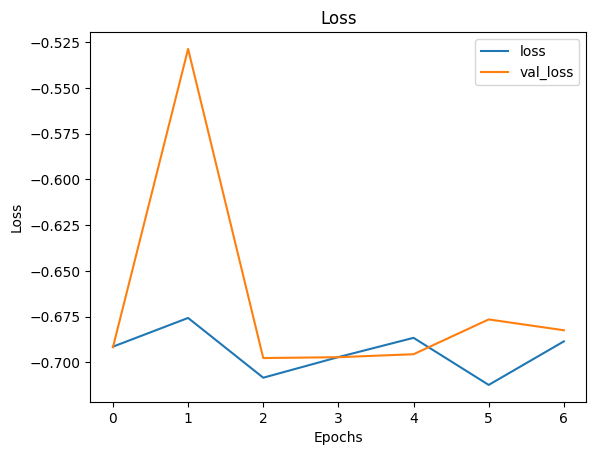

In [22]:
pd.DataFrame(history.history)[["loss", "val_loss"]].plot(title="Loss", xlabel="Epochs", ylabel="Loss")
plt.show()

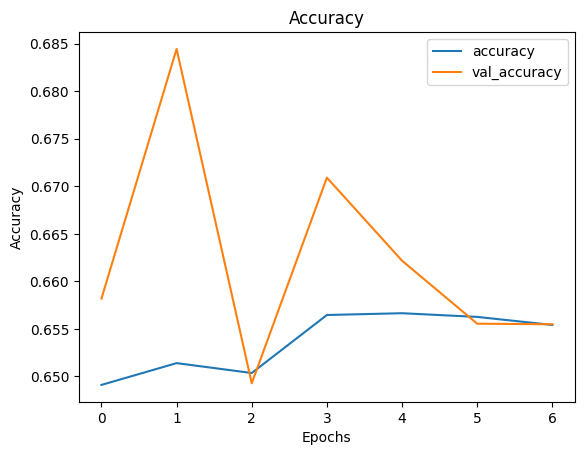

In [24]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(title="Accuracy", xlabel="Epochs", ylabel="Accuracy")
plt.show()

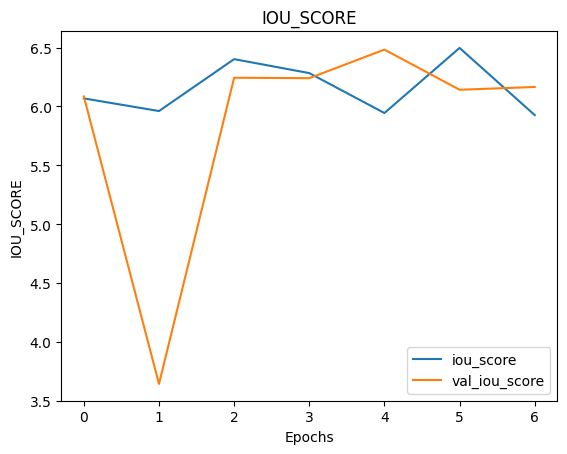

In [28]:
pd.DataFrame(history.history)[["iou_score", "val_iou_score"]].plot(title="IOU_SCORE", xlabel="Epochs", ylabel="IOU_SCORE")
plt.show()

## Model Evaluation

1/1 [==============================] - 0s 34ms/step


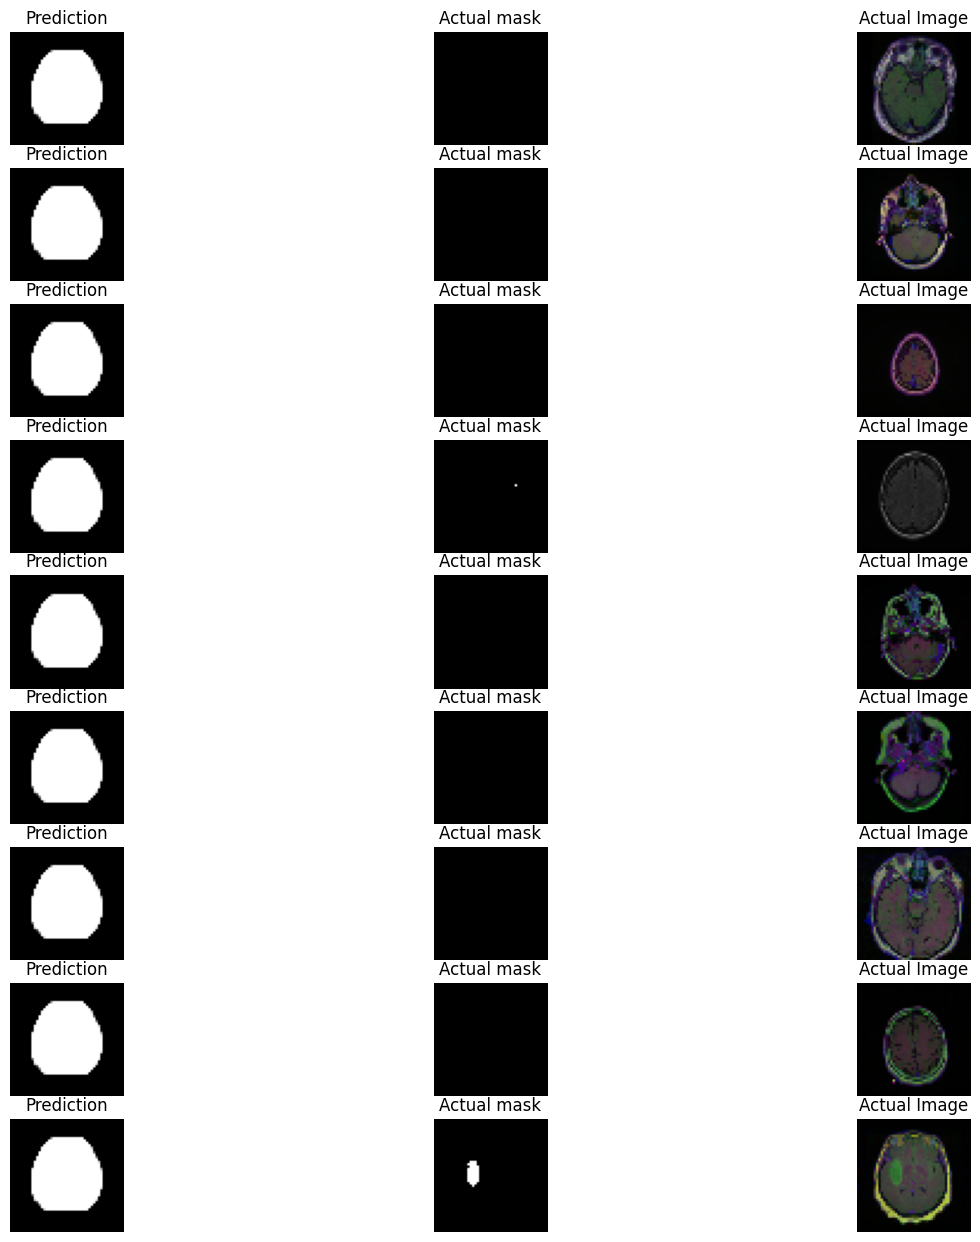

In [68]:
plt.figure(figsize=(15, 15))

for index, (val_img, val_mask) in enumerate(zip(val["image"], val["mask"]), start=1):
    load_mask = keras.utils.img_to_array(keras.utils.load_img(val_mask, target_size=(48, 48))) / 255
    load_image = keras.utils.img_to_array(keras.utils.load_img(val_img, target_size=(48, 48))) / 255
    prediction = unet_model.predict(np.expand_dims(load_image, axis=0))

    plt.subplot(9, 3, index*3 - 2)
    plt.imshow(prediction.reshape(48, 48), cmap='gray')  # Assuming grayscale prediction
    plt.title("Prediction")
    plt.axis("off")
    plt.subplot(9, 3, index*3 - 1)
    plt.imshow(load_mask, cmap='gray')  # Assuming grayscale mask
    plt.title("Actual mask")
    plt.axis("off")
    plt.subplot(9, 3, index*3)
    plt.imshow(load_image)
    plt.title("Actual Image")
    plt.axis("off")

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

##Eddy